# Init

In [1]:
from __future__ import absolute_import, division, print_function

import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.DEBUG,
    format='%(asctime)s %(name)s-%(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S')
import os
import numpy as np
from modules import utils, feature_extraction as fe, postprocessing, visualization
import matplotlib.pyplot as plt

logger = logging.getLogger("beta2")


## Load data 

Data should be in an appropriate format and filtered before when we load it here. It does not have to be scaled. 

In [2]:
feature_type = "CA_inv" # "contacts_5_cutoff" or "CA_inv"
working_dir = os.path.expanduser("~/projects/gpcr/mega/Result_Data/beta2-dror/clustering/{}/".format(feature_type))
raw_data = np.load(working_dir + "samples.npy")
scale_data = True
cluster_indices = np.loadtxt(working_dir + 'cluster_indices_.txt')
data = utils.vectorize(raw_data)  # Our training data to classifiers
labels = utils.create_class_labels(cluster_indices)  #Our training labels to classifiers
feature_to_resids = np.load(
    working_dir + "feature_to_resids.npy")  #Mapping from residue Id to the index of that residue in the data (for proteins with missing residues)
if len(data) != len(labels) or data.shape[1] != len(feature_to_resids):
    raise Exception()
logger.info("Loaded data of shape %s and %s clusters", data.shape, len(set(cluster_indices)))


2018-11-08 18:20:59 beta2-INFO: Loaded data of shape (857, 40186) and 3 clusters


## Define the different methods to use

Every method is encapsulated in a so called FeatureExtractor class which all follow the same interface

In [3]:
n_iterations, n_splits = 1, 1
rbm_data = np.copy(data)
np.random.shuffle(rbm_data)
filter_by_distance_cutoff, filter_by_DKL, filter_by_KS_test = False, False, False 
feature_extractors = [
    fe.MlpFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, hidden_layer_sizes=(100, 50, 25),
                           filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    fe.RbmFeatureExtractor(rbm_data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations, n_components=32,
                           filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),                           
    #fe.ElmFeatureExtractor(data, labels, n_splits=n_splits, n_iterations=n_iterations,
                           #filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    fe.KLFeatureExtractor(data, cluster_indices, n_splits=n_splits,
                           filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    fe.PCAFeatureExtractor(data, cluster_indices, n_splits=n_splits,
                           filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
    fe.RandomForestFeatureExtractor(data, cluster_indices, n_splits=n_splits, n_iterations=n_iterations,
                           filter_by_distance_cutoff=filter_by_distance_cutoff, filter_by_DKL=filter_by_DKL, filter_by_KS_test=filter_by_KS_test),
]
logger.info("Done. using %s feature extractors", len(feature_extractors))


2018-11-08 18:20:59 beta2-INFO: Done. using 5 feature extractors


# Run the relevance analysis

In [8]:
results = []
for extractor in feature_extractors:
    logger.info("Computing relevance for extractors %s", extractor.name)
    feature_importance, std_feature_importance, errors = extractor.extract_features()
    #logger.info("Get feature_importance and std of shapes %s, %s", feature_importance.shape, std_feature_importance.shape)
    results.append((extractor, feature_importance, std_feature_importance, errors))
logger.info("Done")


2018-11-08 18:25:23 beta2-INFO: Computing relevance for extractors MLP
2018-11-08 18:25:23 Extracting features-INFO: Performing feature extraction with MLP on data of shape (857, 40186)
2018-11-08 18:25:27 Extracting features-INFO: Using all data in training and validation sets
2018-11-08 18:25:46 Extracting features-INFO: Done with MLP
2018-11-08 18:25:46 Extracting features-INFO: ------------------------------
2018-11-08 18:25:46 beta2-INFO: Computing relevance for extractors RBM
2018-11-08 18:25:46 Extracting features-INFO: Performing feature extraction with RBM on data of shape (857, 40186)
2018-11-08 18:25:51 Extracting features-INFO: Using all data in training and validation sets
2018-11-08 18:26:34 Extracting features-INFO: Done with RBM
2018-11-08 18:26:34 Extracting features-INFO: ------------------------------
2018-11-08 18:26:34 beta2-INFO: Computing relevance for extractors KL
2018-11-08 18:26:34 Extracting features-INFO: Performing feature extraction with KL on data of sha

# Remap and persist results 

In [11]:
postprocessors = []
for (extractor, feature_importance, std_feature_importance, errors) in results:
    p = postprocessing.PostProcessor(extractor, feature_importance, std_feature_importance, errors, cluster_indices,
                                     working_dir, feature_to_resids=feature_to_resids, filter_results=True)
    p.average()
    p.persist()
    postprocessors.append(p)

logger.info("Done")


2018-11-08 18:37:17 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-11-08 18:37:18 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-11-08 18:37:18 postprocessing-DEBUG: Not possible to compute importance per cluster
2018-11-08 18:37:18 beta2-INFO: Done


# Visualize results

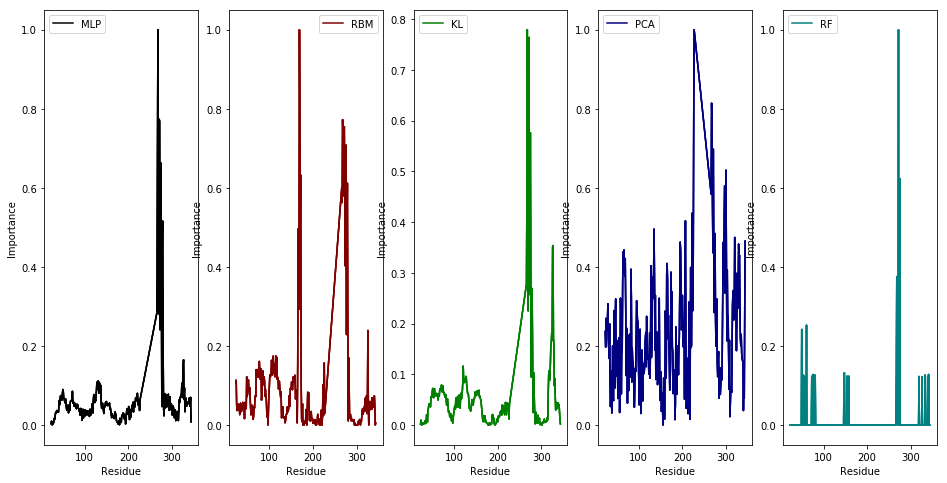

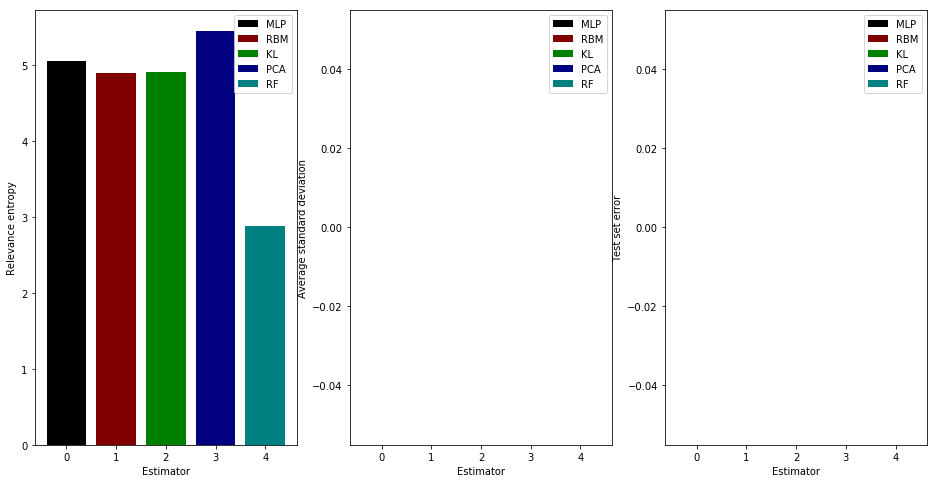

2018-11-08 18:37:22 beta2-INFO: Done


In [12]:
visualization.visualize(postprocessors)
logger.info("Done")